**Updated** Updating the data prep to create a gene based tokenization. 

In [1]:
import gseapy as gp
from tqdm import tqdm
import json
from pathlib import Path
import scanpy as sc
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('/home/ubuntu/data/ac_model')
clean_path = data_dir / 'cleaned_replogle_k562.h5ad' # original from https://virtualcellmodels.cziscience.com/dataset/k562-essential-perturb-seq
tokenized_dir = data_dir / 'tokenized'
train_dir = tokenized_dir / 'train'
val_dir =  tokenized_dir / 'val'
chunk_size = 10000        # How many cells per .npy file
n_pathways = 1024          # Number of pathway "tokens" per cell
n_genes = 4096
count_normalize_target = 1e4 # normalize each cell to this count

## Data Load and Explore

The processed dataset is a single, filtered H5ad file. The .X matrix contains the per-cell gene perturbation counts as provided by the authors. Pertrubation counts are based on CRISPR-based screens with single-cell RNA-sequencing readouts. Within this file, there is unstructured data that contains two sets of differentially expressed genes for each condition, one determined using Wilcoxon rank-sum test and the second by t-test. The unstructured data also contains a mapping between control and target cells for each condition as determined by GEM group and library size (UMI count).

In [3]:
adata = sc.read_h5ad(clean_path)

**Cell metadata** (`adata.obs`)

This dataset is a collection of RNA expression counts based on single cell data.  `obs` indexes out the single cell metadata for each cell in the dataset.  Note that when we downloaded the original dataset we filtered the data to only include cells with info on at least 200 genes and info for genes that were detected in at least 3 cells. We can see that this filtering left us with 310385 cells. 

In the cell metadata, 2 columns in particular are important: 
1. `batch` which links control and perturbed cells together
2. `perturbation`which tells us if the cell is a `control` or which gene was knocked out

In [4]:
adata.obs.columns

Index(['batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id',
       'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor',
       'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex',
       'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type',
       'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes'],
      dtype='object')

In [5]:
adata.obs.shape

(310385, 25)

In [6]:
adata.obs.head()

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,age,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo,n_genes
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,ENSG00000145414,P1P2,5449_NAF1_P1P2_ENSG00000145414,NAF1_+_164087918.23-P1P2|NAF1_-_164087674.23-P1P2,0.112083,11438.0,0.013047,0.813253,...,53,NAF1,human,CRISPR,cell_line,11324.0,3332,1,0.225362,3332
AAACCCAAGAACTTCC-31,31,BUB1,ENSG00000169679,P1P2,935_BUB1_P1P2_ENSG00000169679,BUB1_-_111435363.23-P1P2|BUB1_-_111435372.23-P1P2,0.179895,5342.0,-1.522247,0.844107,...,53,BUB1,human,CRISPR,cell_line,5257.0,2192,1,0.129732,2192
AAACCCAAGAAGCCAC-34,34,UBL5,ENSG00000198258,P1P2,9534_UBL5_P1P2_ENSG00000198258,UBL5_-_9938639.23-P1P2|UBL5_+_9938801.23-P1P2,0.105287,17305.0,0.384157,1.091537,...,53,UBL5,human,CRISPR,cell_line,17135.0,4002,1,0.236825,4002
AAACCCAAGAATAGTC-43,43,C9orf16,ENSG00000171159,P1P2,1131_C9orf16_P1P2_ENSG00000171159,C9orf16_+_130922603.23-P1P2|C9orf16_+_13092264...,0.099359,30244.0,3.721912,0.948277,...,53,C9orf16,human,CRISPR,cell_line,29717.0,5358,1,0.246828,5358
AAACCCAAGACAGCGT-28,28,TIMM9,ENSG00000100575,P1P2,8927_TIMM9_P1P2_ENSG00000100575,TIMM9_-_58893843.23-P1P2|TIMM9_-_58893848.23-P1P2,0.137623,8407.0,-0.975371,0.868942,...,53,TIMM9,human,CRISPR,cell_line,8261.0,2944,1,0.183392,2944


**Batch 27**

Let's look at a single batch.  We'll randomly pick 27 and a few common columns out.  Here we can see that we have a non-targetting/control along with 7736 other perturbation.  Each perturbation in this case is CRISPR knockout of a single gene.  In other datasets you might see introduction of a drug so this can become important as we expand the dataset.  Another key piece to keep in the back of the mind right now is that even our control is cancerous (`disease == chronic myeloid leukemia`).  A couple other userful pieces in the cell metadata is ncounts that tells you the total RNA reads for the cell detected and ngenes that tells us the total non-zero genes identified.  These are great filters 

In [7]:
adata.obs[adata.obs.batch == 27][['batch','gene','disease', 'cancer', 'perturbation', 'perturbation_type', 
                                  'tissue_type','ncounts', 'ngenes', 'nperts']]

,batch,gene,disease,cancer,perturbation,perturbation_type,tissue_type,ncounts,ngenes,nperts
cell_barcode,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,chronic myeloid leukemia,True,NAF1,CRISPR,cell_line,11324.0,3332,1
AAACCCAAGCGTCTGC-27,27,non-targeting,chronic myeloid leukemia,True,control,CRISPR,cell_line,14483.0,3916,0
AAACCCAAGCTGGTGA-27,27,CDAN1,chronic myeloid leukemia,True,CDAN1,CRISPR,cell_line,12906.0,3288,1
AAACCCACACCAGCCA-27,27,KDM8,chronic myeloid leukemia,True,KDM8,CRISPR,cell_line,12976.0,3950,1
AAACCCAGTACAAGCG-27,27,CBLN1,chronic myeloid leukemia,True,CBLN1,CRISPR,cell_line,17600.0,4361,1
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGGACCTC-27,27,SRBD1,chronic myeloid leukemia,True,SRBD1,CRISPR,cell_line,17689.0,4246,1
TTTGTTGGTTGGACCC-27,27,TIMM23B,chronic myeloid leukemia,True,TIMM23B,CRISPR,cell_line,8720.0,2829,1
TTTGTTGTCACGGGCT-27,27,PPP2R1A,chronic myeloid leukemia,True,PPP2R1A,CRISPR,cell_line,10801.0,3273,1


## 

**Gene metadata** (`adata.var`)

`var` indexes out the gene metadata that we see expressed in this dataset.  This  corresponds with the columns in `adata.X` and gives you more information on the gene for linking to different datasets or for performing filtering.   Recall that we filtered for genes that were found in at least 3 cells so, if we were to do this manually, we'd use the `ncells` column. We can also see this dataset contains a total of 8563 genes

In [8]:
adata.var.shape

(8563, 15)

In [9]:
adata.var.head()

,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano,ensembl_id,ncounts,ncells,n_cells
gene_name,,,,,,,,,,,,,,,
LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.137594,0.380048,2.762105,1.049733,ENSG00000237491,42707.0,39082,39082
LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.256720,0.520162,2.026184,1.053944,ENSG00000228794,79682.0,68732,68732
NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.975144,1.707837,0.864665,1.476706,ENSG00000188976,613055.0,248759,248759
KLHL17,chr1,960584,965719,gene_version14,+,5135,True,0.119593,0.353702,2.957540,1.046089,ENSG00000187961,37120.0,34277,34277
HES4,chr1,998962,1000172,gene_version10,-,1210,True,0.249577,0.561933,2.251540,1.265214,ENSG00000188290,77465.0,62316,62316


**Cell X Gene Matrix** (`adata.X`)

`adata.X` is the count matrix (cells × genes) that stores our expression values. We can see that this has as a result 310385 rows (the cells) and 8563 columns (the genes expressed).  The matrix will fill in 0 for the rows not expressed. During preprocessing, we did 2 normalizations on the count frequency: 
1. `sc.pp.normalize_total(adata, target_sum=1e4)`: We rescaled the rows (cells) so that every cell has the same total count (10,000), correcting for technical differences in sequencing depth so cells are directly comparable.
2. `sc.pp.log1p(adata)`: We took the natural logarithm of every value (ln(X+1)), which compressed the range of the data so that a few highly expressed genes don't dominate the analysis (variance stabilization).
Because of this, we can see our values overall are a lot closer together.  

In [10]:
adata.X.shape

(310385, 8563)

In [11]:
adata.X[:10]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 3., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.]], shape=(10, 8563), dtype=float32)

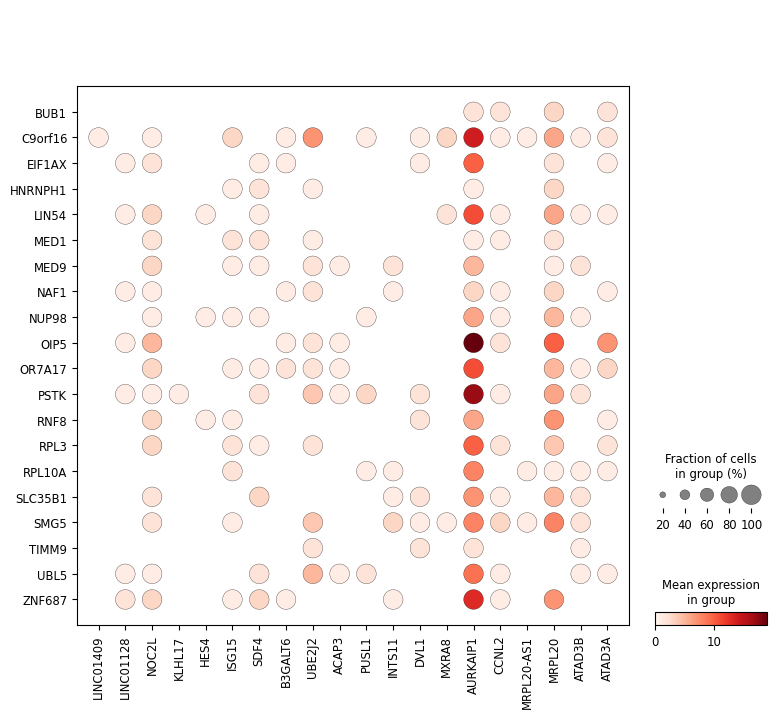

In [12]:
genes_of_interest = adata.var_names[:20] 

# Group by the column in adata.obs (e.g., 'condition' or 'guide_id')
#sc.pl.heatmap(adata, genes_of_interest, groupby='guide_id', cmap='viridis')
sc.pl.dotplot(adata[:20], genes_of_interest, groupby='perturbation')

## Data Normalization
Our raw data is based on absolute expression. In single cell sequencing, the aboslute numbers are misleading, especially when comparing different datasets. The number is misleading as the counts heavily depending on sequencing depth during sequencing.  Because of this we need to normalize the data. We do our normalization in two steps.  

First, to account for the sequencing depth discrepancies, we'll pick a fixed number of reads (in our case 1e4) and then normalize the counts to that number. This helps ensure that sequencing depth becomes even across the dataset. While overall this is a great equalizer, this step has a side effect where, if a perturbation kills off most expression and makes the cell less than viable, the normalization will inflate the signal from the cells.  To combat this we'll also store the total read count as a column and allow our model to decide how important it is to learn. 

Second, genes express at vastly different levels so we may get a count of 5 for one gene and 500 for another gene. If we kept the raw numbers the model would learn a lot more about the high expression genes as dialing in 10% variance on 500 is far more impactful to the loss than 10% on 5.  By taking the log, we pull the different counts into the same order of magnitude allowing the model the chance to focus on all the networks roughly equally 

*Note that with scverse we do log1p which techincally calculates $X=log(X+1)$ so that no value is <0*

Let's also quickly peak at our expression counts so that we can see how they change after we normalize

In [13]:
adata.X[:3]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 0., 0.]], shape=(3, 8563), dtype=float32)

**Total counts** we'll first calculate the total counts by cell.  Right out of the gate we can see how much they differ

In [14]:
total_counts = np.array(adata.X.sum(axis=1)).flatten()
total_counts[:10]

array([11324.,  5257., 17135., 29717.,  8261., 20566., 18927.,  7437.,
       15164., 20313.], dtype=float32)

**Count Normalization**  now we'll normalize by the cell count. See how they differ from our expression data we showed in the previous cell. 

In [15]:
sc.pp.normalize_total(adata, target_sum=count_normalize_target)
adata.X[:3]

array([[0.       , 0.8830802, 0.8830802, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.9022257, 1.9022257,
        0.       ],
       [0.       , 0.5836008, 0.5836008, ..., 0.5836008, 0.       ,
        0.       ]], shape=(3, 8563), dtype=float32)

**Log normalization** Now we'll apply `log1p` to bring in the variance in our expression counts. 

In [16]:
adata.obs['log_total_counts'] = np.log1p(total_counts)
sc.pp.log1p(adata)
adata.X[:3]

array([[0.        , 0.6329088 , 0.6329088 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.065478  , 1.065478  ,
        0.        ],
       [0.        , 0.45970124, 0.45970124, ..., 0.45970124, 0.        ,
        0.        ]], shape=(3, 8563), dtype=float32)

**Gene Filtering** 
Finally, humans have ~25K genes so in theory we could have at least that, or more if we include isoforms, in our total expression "vocab". While for a full scale model this isn't that big of a dimension, since we're toying around with experiments, we don't want to keep all these genes around, especially since some of them may be barely expressed in our dataset.  For this reason we'll apply a filter so that we only keep the top N (current 4096) genes that we have data for. 

In [17]:
sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, subset=True)
genes = adata.var_names.tolist()
print(f"Final Feature Space: {len(genes)} genes")

Final Feature Space: 4096 genes


Now we'll go ahead and save the genes for when we need to reference them in the future

In [18]:
with open(data_dir / 'gene_names.json', 'w') as f:
    json.dump(genes, f)

## Reactome Map
For our world model we want to learn about gene expression and related pathways. By learning both the genes and the pathways that link them our model has a better chance to learn the underlying physics.  We'll use one-hot encoding to create a binary `[gene,network]` map.  When we introduce molecules beyond genes, we'll easily be able to add to our feature space and add encodings.  You'll notice that we build this pathway mask but then just save it. This is because the encoded pathways become an input to our transformers where we give the transformer a hint, though we ultimately allow the transformer to decide what pathways to learn. 


To get started we'll use the [Drug Signatures Database (DSigDB)](https://academic.oup.com/bioinformatics/article/31/18/3069/241009) dataset mainly because it has a nice view of the different gene sets that relate drugs/compounds and their target genes.  This will give us a detailed, close to up to date, starting point to work backwards from.  

The dataset we're using is a fairly simple dictionary: it uses the pathway name as the key and then has the gene abbreviation in the items. 

Other datasets considered 
* RummaGEO_GenePerturbations_2025 - 7961
* PerturbAtlas - 7741
* DSigDB - 7540

In [19]:
gs_res = gp.get_library(name='DSigDB', organism='Human')

an example of a pathway

In [20]:
gs_res['epinephrine']

['VDR',
 'KDM4E',
 'RECQL',
 'ADRA2C',
 'MTOR',
 'ADRA2B',
 'ADRA2A',
 'MAPT',
 'APEX1',
 'TDP1',
 'CYP1A2',
 'GAPDH',
 'NFE2L2',
 'FEN1',
 'ADRB1',
 'ADRB2',
 'ADRA1D',
 'ADRB3',
 'HIF1A',
 'ADRA1B',
 'ADRA1A',
 'HSD17B10',
 'CA1',
 'CA4',
 'POLK',
 'DRD1',
 'CA14']

Some regulatory pathways are quite sizeable and others very tiny. Also our DB has a lot of pathways: 4007. Longer term we'd want to include all these pathways, but for now, we want to try to keep long-tails out of our dataset.  If we look at the distribution of genes in each network we see a long top tail.  We'll go ahead and clip the top off to prevent this long tail.  We'll arbitrarily pick all the pathways with more than 80 and less than 1400 genes given that leads to covering most of the genes that we have expression data for without going too wide on our pathway counts. 

In [21]:
len(gs_res.keys())

4007

(array([3606.,  198.,   88.,   41.,   23.,   12.,   20.,    8.,    6.,
           5.]),
 array([  11. ,  205.7,  400.4,  595.1,  789.8,  984.5, 1179.2, 1373.9,
        1568.6, 1763.3, 1958. ]),
 <BarContainer object of 10 artists>)

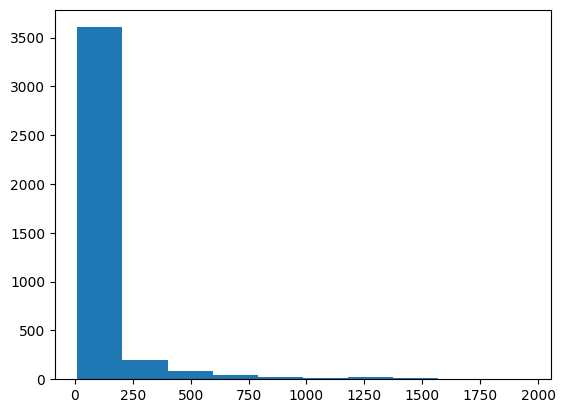

In [22]:
plt.hist([len(v) for k,v in gs_res.items()])

In [23]:
valid_pathways = {k: v for k, v in gs_res.items() if 80 <= len(v) <= 1400}
len(list(valid_pathways.keys())), n_pathways

(1029, 1024)

We can see that even with cutting off the top tail we're still above our target, so we'll arbitrarily just select the first set up to our target number. 

In [24]:
pathway_names = list(valid_pathways.keys())[:n_pathways]
len(pathway_names)

1024

**Compare pathways and expression data for overlap**

We'll now see how many of our total genes we have in our reactome dataset. Recall that we started with 8563

In [25]:
reactome_genes = set(list(sum([v for k, v in valid_pathways.items() if k in pathway_names],[])))
len(reactome_genes)

17137

In [26]:
# genes we have expression for and reactome information for 
f'Of our {len(set(genes))} genes picked, only \
{len(set(genes)) - len(set(genes) - reactome_genes)} show up in a pathway'

'Of our 4096 genes picked, only 3508 show up in a pathway'

## Gene to Network Encoding

Now that we have our gene regulatory network extracted, we want to create an encoding of which genes belong to which networks. To create an array that's workable we'll use a simple one-hot encoding where we create a row for each gene and a column for each network, flag each gene in the network  As a result we get a  matrix similar to the following: 

$$
\begin{bmatrix}
1 & 1 & 0 & 1 & 0 \\
0 & 1 & 1 & 0 & 1 \\
0 & 0 & 0 & 1 & 1 \\
1 & 0 & 1 & 1 & 0
\end{bmatrix}_{gene \times network}
$$


First we'll go through a single example, then we'll create a loop to do all of the networks. We'll first start out by setting up an array of zeros to act as placeholders and a dictionary of our genes so that each network indexs the same gene in the same column. 

In [27]:
binary_mask = np.zeros((len(genes), len(pathway_names)), dtype=np.float32)
gene_to_idx = {gene: i for i, gene in enumerate(genes)}

#### Single Example

For our single example, we'll go ahead and pull out our first  network and hard code a 0 (first index).  This pathway is linked to Clotrimazole, a broad-spectrum antifungal medication.

In [28]:
p_idx, p_name = 0, pathway_names[0]
p_idx, p_name

(0, 'clotrimazole')

Next we'll index out the different genes in this pathway.  We can see that there's 87 different genes in this pathway 

In [29]:
genes_in_pathway = valid_pathways[p_name]
len(genes_in_pathway), genes_in_pathway

(87,
 ['KDM4A',
  'SLC12A5',
  'HSP90AA1',
  'JUN',
  'AVPR2',
  'GPR55',
  'CBX1',
  'OPRM1',
  'TACR1',
  'TACR2',
  'PPP1CA',
  'CYP2C9',
  'ADORA2A',
  'CYP1A2',
  'CDK1',
  'KCNK3',
  'NFE2L2',
  'RAPGEF4',
  'TP53',
  'ACHE',
  'CHRM3',
  'CHRM4',
  'ABCB1',
  'CHRM1',
  'CHRM2',
  'OPRD1',
  'GLP1R',
  'NR1I3',
  'HTR2C',
  'ADRB1',
  'ADRB2',
  'AHR',
  'HTR2A',
  'ADRA1D',
  'ADRB3',
  'CYP3A4',
  'HTR2B',
  'HSPB1',
  'CA2',
  'HRH2',
  'ATXN2',
  'HRH1',
  'CYSLTR1',
  'THPO',
  'CYP2D6',
  'CFL1',
  'ADORA3',
  'DRD1',
  'ADORA1',
  'DRD2',
  'DRD3',
  'DRD4',
  'CCR4',
  'KCNH2',
  'NPSR1',
  'CYP51A1',
  'OPRK1',
  'NR1H4',
  'ESR1',
  'ADRA2B',
  'ADRA2A',
  'TSHR',
  'AR',
  'KCNQ1',
  'TBXAS1',
  'TDP1',
  'PPARG',
  'PPARD',
  'GMNN',
  'PTAFR',
  'BAZ2B',
  'HIF1A',
  'SLC6A2',
  'CYP2C19',
  'HTR6',
  'NR3C1',
  'SLC6A3',
  'CYP19A1',
  'SLC6A4',
  'PTGS2',
  'CYP17A1',
  'TRPM2',
  'CXCR1',
  'MAPK1',
  'FYN',
  'KCNN4',
  'CYTH2'])

**One-hot encoding**

Now that we have the genes, we'll go through each gene, see if it appears in our expression matrix list `gene_to_idx`.  If it does, we'll add a `1` to that row index.  Since we saw that not all of our genes picked are in the network, and vice versa, we won't necessarily see the full network encoded. This doesn't matter as much as we this network map is meerly a hint as to the relationships but we more want our model to learn the relationships that help it best understand the impact of perturbations. 

In [30]:
hit_count = 0
genes_in_pathway = valid_pathways[p_name]
for g in genes_in_pathway:
    if g in gene_to_idx:
        binary_mask[gene_to_idx[g], p_idx] = 1.0
        hit_count += 1

if hit_count <= 1:
    print(f'pathway {p_name} had {hit_count} gene hits')

Now let's index out one of the hits `KDM4A` and see that it matches what we expect, 1.0

In [31]:
binary_mask[gene_to_idx['KDM4A'],0]

np.float32(1.0)

#### Batch Run

Now that we've done it for the first pathway, to save time/space we'll run this for all the 1024 networks we've filtered to.  We'll reinitialize our gene mask and run it for all the genes. We have a message that tells us if a pathway only had 1 or 0 gene hits in it. This would tell us that likely that pathway is too sparse in our training and potentially should be filtered.  Eventually we'll add automated filtering into our data prep once we have it dialed in. 

In [32]:
binary_mask = np.zeros((len(genes), len(pathway_names)), dtype=np.float32)
for p_idx, p_name in enumerate(pathway_names):
    hit_count = 0
    genes_in_pathway = valid_pathways[p_name]
    for g in genes_in_pathway:
        if g in gene_to_idx:
            binary_mask[gene_to_idx[g], p_idx] = 1.0
            hit_count += 1

    if hit_count <= 1:
    	print(f'pathway {p_name} had {hit_count} gene hits')

Even though we didn't see any messages print out, let's run a quick sanity check to ensure we truely don't have any empty pathways. 

In [33]:
np.where(np.all(binary_mask == 0, axis=0) == True)

(array([], dtype=int64),)

Finally, we'll go ahead and cache our binary network map and pathway name to ID mappings so that if we needed to run this again or augment our data we don't have to process all of our examples from scratch. 

In [34]:
# Save Pathway Names for analysis later
np.save(data_dir / 'binary_pathway_mask.npy', binary_mask)
with open(data_dir /'pathway_names.json', 'w') as f:
    json.dump(pathway_names, f)

## Create Case/Control Pairs

Now that we have our data normalized and pathways cached away, we'll actually need to create our case control pairing. The pairings we're building pair together a control cell and a case cell (perturbed) for the same batch id.  In this pairing we'll need to get 
1. control cell's expression counts by gene
2. control cell's total expression count
3. case cell's expression counts by gene
4. case cell's total expression count
5. case cell's perturbation

In our dataset we have multiple control cells per batch yet we have more case cells than controls for each batch. Because of this, when we do our pairing we'll take a case cell and pick a random control cell from the batch to pair it with. 

Since we have way less control cells than case cells, we'll first start by creating a cache of our control cells.  

### Control Encoding. 

Let's start with the control. Recall that a batch can have multiple cotrol cells so we'll need to process the whole control batch at a time.  We'll start by creating a list of just the control cells.

In [35]:
COL_PERTURBATION = 'perturbation'  # The gene being knocked down
COL_CONTROL_LABEL = 'control' # The label string for control cells
COL_BATCH = 'batch' # Batch column (if available) to match controls/case within same batch

In [36]:
is_control = adata.obs[COL_PERTURBATION].str.contains(COL_CONTROL_LABEL, case=False, na=False)
control_indices = np.where(is_control)[0]
adata.obs[is_control].head() # shows only true

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo,n_genes,log_total_counts
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGAGGAG-47,47,non-targeting,non-targeting,non-targeting,11059_non-targeting_non-targeting_non-targeting,non-targeting_02010|non-targeting_01147,0.092709,12221.0,1.096669,0.600264,...,control,human,CRISPR,cell_line,12045.0,3265,0,0.280282,3265,9.396488
AAACCCAAGCGTCTGC-27,27,non-targeting,non-targeting,non-targeting,11020_non-targeting_non-targeting_non-targeting,non-targeting_01763|non-targeting_02345,0.087307,14638.0,0.760877,0.813253,...,control,human,CRISPR,cell_line,14483.0,3916,0,0.204516,3916,9.580800
AAACCCAAGGAGGGTG-47,47,non-targeting,non-targeting,non-targeting,11097_non-targeting_non-targeting_non-targeting,non-targeting_02274|non-targeting_01075,0.144649,11241.0,0.813080,0.600264,...,control,human,CRISPR,cell_line,11118.0,2999,0,0.239701,2999,9.316411
AAACCCAAGTACCCTA-20,20,non-targeting,non-targeting,non-targeting,11320_non-targeting_non-targeting_non-targeting,non-targeting_03721|non-targeting_02172,0.101813,20302.0,1.392648,1.030337,...,control,human,CRISPR,cell_line,20073.0,4177,0,0.248991,4177,9.907181
AAACCCAAGTGTTCAC-3,3,non-targeting,non-targeting,non-targeting,10969_non-targeting_non-targeting_non-targeting,non-targeting_01395|non-targeting_02523,0.085352,16098.0,0.087551,1.112076,...,control,human,CRISPR,cell_line,15898.0,3987,0,0.247578,3987,9.674011


#### Single Example

Let's first pull out the first entry index and expression data from our filtered down controls.

In [37]:
idx_chunk = control_indices[0]
idx_chunk

np.int64(31)

**Load expression** first we'll load the expression information.  This is the information we normalized earlier. 

In [38]:
raw_chunk = adata[idx_chunk].X
raw_chunk = raw_chunk.toarray()
raw_chunk

array([[0.       , 0.       , 0.       , ..., 0.6044362, 0.       ,
        0.       ]], shape=(1, 4096), dtype=float32)

**Load total expression** next we'll load the total expression counts. We precalculated this for every cell so we just need to index it out. 

In [39]:
total_chunk = adata.obs.iloc[idx_chunk]['log_total_counts']
total_chunk

np.float32(9.396488)

**Append Batch Info**

Now that we have our network impact, we need to save it for the batch.  We'll extract the batch ID from the control cell metadata.  We'll then create an entry in our collection for the batch ID and append the network impact array to it.  We have to append to the collection entry since we have more than one control cell for a batch. 

In [40]:
batch_ids = adata.obs.iloc[[idx_chunk]][COL_BATCH].values
batch_ids

array([47])

In [41]:
control_cache = collections.defaultdict(lambda: {'X': [], 'total': []})
for b_id, vec, tot in zip(batch_ids, raw_chunk, [total_chunk]):
        control_cache[b_id]['X'].append(vec)
        control_cache[b_id]['total'].append(tot)
control_cache

defaultdict(<function __main__.<lambda>()>,
            {np.int64(47): {'X': [array([0.       , 0.       , 0.       , ..., 0.6044362, 0.       ,
                      0.       ], shape=(4096,), dtype=float32)],
              'total': [np.float32(9.396488)]}})

#### Batch Run

Now that we've done it for the first Control, to save time/space we'll run this for all 10,691 control cells we have. We'll reinitialize our collection and run it for all the cells. To speed this along we'll also run it in batches of 10 cells at a time.  Based on the dataset size and resource constraints we can increase or decrease the batch size.   

In [42]:
control_cache = collections.defaultdict(lambda: {'X': [], 'total': []})
batch_size = 10

for i in tqdm(range(0, len(control_indices), batch_size), desc='Caching Controls'):
    idx_chunk = control_indices[i : i+batch_size]
    
    # Load Raw Genes
    raw_chunk = adata[idx_chunk].X
    raw_chunk = raw_chunk.toarray()
    
    # Load Totals
    total_chunk = adata.obs.iloc[idx_chunk]['log_total_counts'].values
    
    # Group by Batch
    batch_ids = adata.obs.iloc[idx_chunk][COL_BATCH].values
    
    for b_id, vec, tot in zip(batch_ids, raw_chunk, total_chunk):
        control_cache[b_id]['X'].append(vec)
        control_cache[b_id]['total'].append(tot)

# Convert lists to numpy arrays for fast sampling
for k in control_cache:
    control_cache[k]['X'] = np.array(control_cache[k]['X'], dtype=np.float32)
    control_cache[k]['total'] = np.array(control_cache[k]['total'], dtype=np.float32)

Caching Controls: 100%|████████████████████████████████████████████████████| 1070/1070 [00:03<00:00, 272.36it/s]


**Sanity Check** Now that we've extracted all the batches, let's ensure that our collection is indeed as long as the unique batches that we have in our raw data.  

In [43]:
len(set(adata.obs.iloc[control_indices].batch)) == len(control_cache.keys())

True

### Create a pair of the control and case

Now that we've processed our controls, we need to process our case and cache our tokenized data. In this process we extract a pertrubed cell (case), we encode it's perturbation, we pull a control example randomly from the same batch, and then we save the data for use later. Lucky for us our current dataset already has the cells in random order so we don't need to shuffle it.  If we had all our cells ordered by batch, we might see weird learning rates emerge. 

Once again I'll go through one example and then run the process in large batches.  

Let's first create a dictionary for our perturbations so that we can convert them to an integer for learning. We'll also go ahead and save this. 

In [44]:
all_perturbations = adata.obs[COL_PERTURBATION].unique()
pert_to_id = {p: i for i, p in enumerate(all_perturbations)}

In [45]:
with open(data_dir/'perturbation_map.json', 'w') as f:
    json.dump({str(k): int(v) for k, v in pert_to_id.items()}, f)

Next let's create a list of which cells are our case. *Note* that here we start using the word "case" to indicate our perturbed cells. 

In [46]:
case_indices = np.where(~is_control)[0]
n_case = len(case_indices)
n_case

299694

#### Single Example

Let's first pull out the first entry from our perturbed cells. Lucky for us it's the very first entry of the dataset.  After we have it we'll also extract it's expression data 

In [47]:
idx_chunk = case_indices[0]
idx_chunk

np.int64(0)

**Load expression** first we'll load the expression information.  This is the information we normalized earlier. 

In [48]:
chunk_adata = adata[idx_chunk]
case_X = chunk_adata.X
case_X = case_X.toarray()
case_X

array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 4096), dtype=float32)

**Load total expression** next we'll load the total expression counts. We precalculated this for every cell so we just need to index it out. 

In [49]:
case_total = chunk_adata.obs['log_total_counts'].values
case_total

array([9.334768], dtype=float32)

**Encode Perturbation**

Next we'll need to convert the perturbation to an ID for training.  Recall that we created a dictionary earlier to map our gene perturbations to an integer.  We'll use our case cell's metadata to extract the perturbation and then use the dictionary to convert that into an ID. 

In [50]:
pert_names = chunk_adata.obs[COL_PERTURBATION].values
pert_ids = [pert_to_id[p] for p in pert_names]
pert_ids, pert_names

([0],
 ['NAF1']
 Categories (1, object): ['NAF1'])

**Link Control through Batch ID**

Now that we have our case expression infromation and perturbation encoded, we need to get the batch ID so that we can then go to our collection and sample out a control cell to pair with our perturbed cell. We'll start by extracting the batch ID from the case cell's metadata. 

In [51]:
batch_ids = chunk_adata.obs[COL_BATCH].values 
batch_ids

array([27])

Now that we have our batch ID we need to extract a control cell for the batch. Recall that we created a collection (or dictionary) to store the controls by batch ID so we simply index out the batch from that collection.  Once we have the controls for the batch, we are ready to sample an exmaple from the pool of controls. 

When we add other datasets, we'll need to make this more robust where, if there is not a perfect control for this specific batch, we'll either need to use another control from the dataset or a synthetic one for the lineage 

In [52]:
matched_X = []
matched_total = []

pool_X = control_cache[b_id]['X']
pool_total = control_cache[b_id]['total']
len(pool_X), len(pool_total)

(214, 214)

**Sampling a control**

Since we often have more than 1 control from the batch for our current dataset, we'll randomly sample from the control for our perturbation.  We happen to know that we don't have a perfect 1:1 mapping of control to perturbation, in fact we have way less controls, so our best bet is to randomly sample.  Other methods could be to create a mean control or some other average method, but for now we'll just use random sampling

In [53]:
rand_idx = np.random.randint(len(pool_X))
rand_idx

22

In [54]:
matched_X.append(pool_X[rand_idx])
matched_total.append(pool_total[rand_idx])
matched_X, matched_total

([array([0., 0., 0., ..., 0., 0., 0.], shape=(4096,), dtype=float32)],
 [np.float32(9.33247)])

**Creating the link**

Now that we have our perturbation encoding, our case cell network impact, and our control cell network impact, our next part would be to save a compressed file of the linkages.  Since this is just a single example, i'll create a dictionary example

In [55]:
{
    'control':matched_X,
    'control_total': matched_total,
    'case':case_X,
    'case_total':case_total,
    'action_ids':pert_ids
}

{'control': [array([0., 0., 0., ..., 0., 0., 0.], shape=(4096,), dtype=float32)],
 'control_total': [np.float32(9.33247)],
 'case': array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 4096), dtype=float32),
 'case_total': array([9.334768], dtype=float32),
 'action_ids': [0]}

#### Batch Run

Now that we've walked through a single example, to save time/space we'll run this for all of the control cells we have. Since this will be our final finals used by our data loader for training, we want to make sure we create files that are at least as big as a batch but not too big to destory our memory when they're loaded. We'll start with an arbitrary 10K cells per file.  This corresponds to 10K case cells, their matched controls, and their perturbation embeddings. Depending on the training hardware and the tokenization you may need to change the chunk_size. 

We'll also spin out the first full file as our validation file to act as a held-out set 

In [56]:
shard_counter = 0

In [57]:
for i in tqdm(range(0, n_case, chunk_size), desc='Processing Pairs'):
    idx_chunk = case_indices[i : i+chunk_size]
    
    # Load Case Data
    chunk_adata = adata[idx_chunk]
    case_X = chunk_adata.X
    case_X = case_X.toarray()
    
    # Case Totals
    case_total = chunk_adata.obs['log_total_counts'].values
    
    # Get Metadata
    batch_ids = chunk_adata.obs[COL_BATCH].values 
    pert_names = chunk_adata.obs[COL_PERTURBATION].values
    pert_ids = [pert_to_id[p] for p in pert_names]
    
    # Find Pairs
    matched_X = []
    matched_total = []

    for j, b_id in enumerate(batch_ids):
        # Try to find control from same batch
        if b_id in control_cache:
            pool_X = control_cache[b_id]['X']
            pool_total = control_cache[b_id]['total']

            rand_idx = np.random.randint(len(pool_X))

            matched_X.append(pool_X[rand_idx])
            matched_total.append(pool_total[rand_idx])

        else:
            # Fallback to any control if batch missing
            print(f'cannot find control for batch {b_id}')
            break
            # pool = control_cache[list(control_cache.keys())[0]]
        

    # Convert lists to arrays
    matched_X = np.array(matched_X, dtype=np.float32)
    matched_total = np.array(matched_total, dtype=np.float32)

    
    # Save to buffers
    
    save_dir = val_dir if i == 0 else train_dir
    
    np.savez(
        save_dir / f'shard_{shard_counter:04d}.npz',
        control=matched_X,         # [N, 2000] Normalized
        control_total=matched_total, # [N] Log(Total_Counts)
        case=case_X,               # [N, 2000] Normalized
        case_total=case_total,       # [N] Log(Total_Counts)
        action_ids=pert_ids
    )
    shard_counter += 1

Processing Pairs: 100%|█████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.41it/s]
